In [3]:
import numpy as np
import xarray as xr
import xesmf as xe
import matplotlib.pyplot as plt

/N/u/gongg/Quartz/anaconda3/envs/xesmf/lib/python3.10/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(


In [14]:
ds_404 = xr.open_dataset('/N/project/Zli_lab/Data/Observations/NCAR/prec_acc_files/PREC_ACC_NC.wrf2d_d01_2022-09-30_23:00:00.nc')

In [4]:
ds_era = xr.open_dataset('era_refer_202209302300.nc')

In [6]:
import xarray as xr
import xesmf as xe
import numpy as np

# 计算网格边界的辅助函数
def compute_bounds(coord):
    """
    计算网格边界，假设均匀网格
    coord: xarray DataArray (1D 或 2D)
    返回: 网格边界 (与输入 coord 形状不同, 但匹配重网格化需求)
    """
    coord_diff = np.diff(coord) / 2  # 计算网格间距
    coord_b = np.zeros(len(coord) + 1)  # 创建边界数组
    coord_b[1:-1] = coord[:-1] + coord_diff  # 计算内部边界
    coord_b[0] = coord[0] - coord_diff[0]  # 计算左/下边界
    coord_b[-1] = coord[-1] + coord_diff[-1]  # 计算右/上边界
    return coord_b

# 计算 ds_404 的网格边界
lat_b_404 = compute_bounds(ds_404["XLAT"].values[:, 0])  # 只取南北方向
lon_b_404 = compute_bounds(ds_404["XLONG"].values[0, :])  # 只取东西方向

# 计算 ds_era 的网格边界
lat_b_era = compute_bounds(ds_era["latitude"].values)  # 1D
lon_b_era = compute_bounds(ds_era["longitude"].values)  # 1D

# 创建 2D 网格
lon_era_2d, lat_era_2d = np.meshgrid(ds_era["longitude"].values, ds_era["latitude"].values)
lon_b_era_2d, lat_b_era_2d = np.meshgrid(lon_b_era, lat_b_era)

# 创建 ds_404 的重网格数据集
ds_404_grid = xr.Dataset(
    {
        "lon": (["south_north", "west_east"], ds_404["XLONG"].values),
        "lat": (["south_north", "west_east"], ds_404["XLAT"].values),
        "lon_b": (["west_east_b"], lon_b_404),
        "lat_b": (["south_north_b"], lat_b_404),
    }
)

# 创建 ds_era 的重网格数据集
ds_era_grid = xr.Dataset(
    {
        "lon": (["latitude", "longitude"], lon_era_2d),
        "lat": (["latitude", "longitude"], lat_era_2d),
        "lon_b": (["latitude_b", "longitude_b"], lon_b_era_2d),
        "lat_b": (["latitude_b", "longitude_b"], lat_b_era_2d),
    }
)

# 创建 conservative 重网格化器
regridder = xe.Regridder(ds_404_grid, ds_era_grid, "conservative", reuse_weights=False)

# 进行重网格化
ds_404_regridded = regridder(ds_404["PREC_ACC_NC"])

# 将重网格化数据添加到 ds_era
ds_era["PREC_ACC_NC_regridded"] = ds_404_regridded



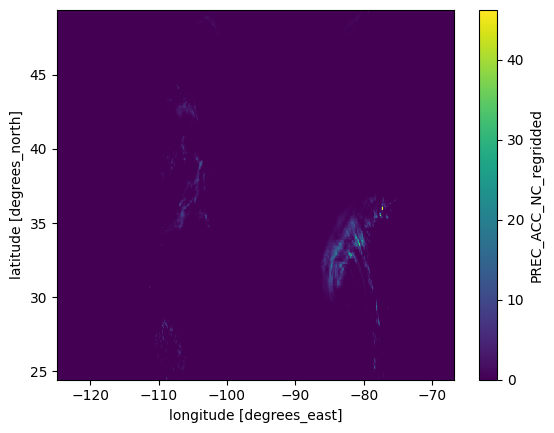

In [7]:
ds_era["PREC_ACC_NC_regridded"].mean('Time').plot()

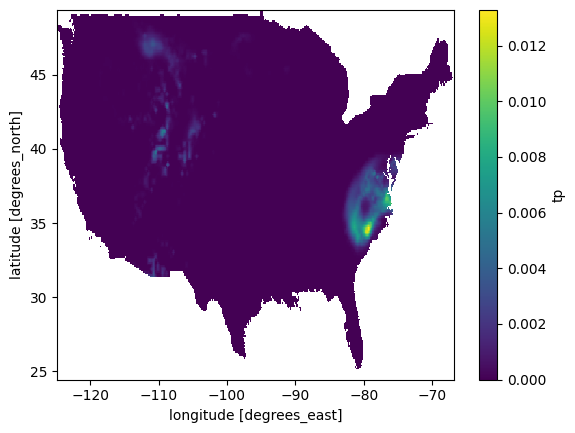

In [8]:
ds_era["tp"].mean('time').plot()

In [11]:
dsss1 = xr.open_dataset('remapping/remapp_404_202107312300.nc')
dsss2 = xr.open_dataset('remapping/remapp_404_202209302300.nc')

## retry

In [9]:
import numpy as np
import xarray as xr
import xesmf as xe

# 创建 2D 网格
ds_era_lon, ds_era_lat = np.meshgrid(ds_era.longitude.values, ds_era.latitude.values, indexing='xy')

# 确保 ds_era 具有 2D 经纬度坐标
ds_era = ds_era.assign_coords(
    lon_2d=xr.DataArray(ds_era_lon, dims=("latitude", "longitude"), coords={"latitude": ds_era.latitude, "longitude": ds_era.longitude}),
    lat_2d=xr.DataArray(ds_era_lat, dims=("latitude", "longitude"), coords={"latitude": ds_era.latitude, "longitude": ds_era.longitude})
)


In [10]:
def compute_bounds_1d(coord):
    """
    计算 1D 经纬度边界（适用于均匀网格）
    """
    coord_diff = np.diff(coord) / 2
    coord_b = np.zeros(len(coord) + 1)
    coord_b[1:-1] = coord[:-1] + coord_diff
    coord_b[0] = coord[0] - coord_diff[0]
    coord_b[-1] = coord[-1] + coord_diff[-1]
    return coord_b

# 计算 ds_era 的经纬度边界
lat_b_era = compute_bounds_1d(ds_era.latitude.values)
lon_b_era = compute_bounds_1d(ds_era.longitude.values)

# 计算 ds_404 的经纬度边界
lat_b_404 = compute_bounds_1d(ds_404["XLAT"][:, 0].values)  # 仅取南北方向
lon_b_404 = compute_bounds_1d(ds_404["XLONG"][0, :].values)  # 仅取东西方向


In [11]:
# 生成 ds_era 的 2D 边界
lon_b_era_2d, lat_b_era_2d = np.meshgrid(lon_b_era, lat_b_era)

# 创建 ds_era 网格数据集
ds_era_grid = xr.Dataset(
    {
        "lon": (["latitude", "longitude"], ds_era["lon_2d"].values),
        "lat": (["latitude", "longitude"], ds_era["lat_2d"].values),
        "lon_b": (["latitude_b", "longitude_b"], lon_b_era_2d),
        "lat_b": (["latitude_b", "longitude_b"], lat_b_era_2d),
    }
)

# 创建 ds_404 网格数据集
ds_404_grid = xr.Dataset(
    {
        "lon": (["south_north", "west_east"], ds_404["XLONG"].values),
        "lat": (["south_north", "west_east"], ds_404["XLAT"].values),
        "lon_b": (["west_east_b"], lon_b_404),
        "lat_b": (["south_north_b"], lat_b_404),
    }
)


In [13]:
ds_404_grid

<xarray.Dataset> Size: 11MB
Dimensions:  (south_north: 1015, west_east: 1367, west_east_b: 1368,
              south_north_b: 1016)
Dimensions without coordinates: south_north, west_east, west_east_b,
                                south_north_b
Data variables:
    lon      (south_north, west_east) float32 6MB -122.6 -122.5 ... -57.07
    lat      (south_north, west_east) float32 6MB 17.65 17.66 ... 51.71 51.69
    lon_b    (west_east_b) float64 11kB -122.6 -122.6 -122.5 ... -73.24 -73.21
    lat_b    (south_north_b) float64 8kB 17.63 17.66 17.7 ... 51.65 51.68 51.71

In [15]:
# 创建 Conservative 重网格化器
regridder = xe.Regridder(ds_404_grid, ds_era_grid, "conservative", filename="weights.nc", reuse_weights=False)



In [16]:
regridder

xESMF Regridder 
Regridding algorithm:       conservative 
Weight filename:            weights.nc 
Reuse pre-computed weights? False 
Input grid shape:           (1015, 1367) 
Output grid shape:          (249, 580) 
Periodic in longitude?      False

In [17]:

# 进行重网格化
ds_404_regridded = regridder(ds_404["PREC_ACC_NC"])

# 将数据添加回 ds_era
ds_era["PREC_ACC_NC_regridded"] = ds_404_regridded

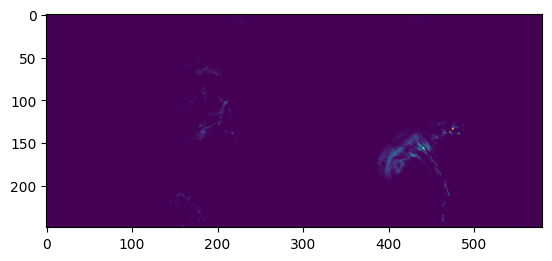

In [23]:
plt.imshow(ds_404_regridded.values[0])

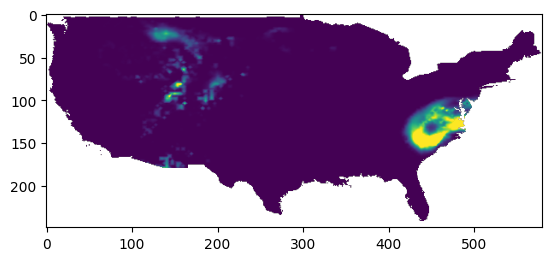

In [28]:
plt.imshow(ds_era.tp.values[0]*1000,vmin=0,vmax=5)

In [29]:
mask = ~np.isnan(ds_era.tp.values[0])  # 只保留有效数据区域

# 使用 mask 进行裁剪
arr_404_ = np.where(mask, ds_404_regridded.values[0], np.nan) 

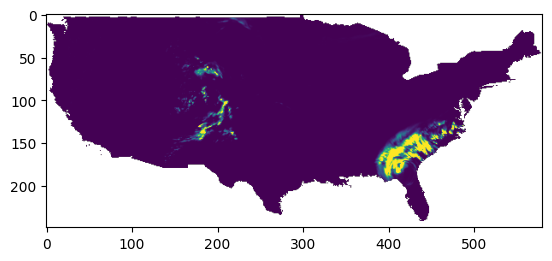

In [31]:
plt.imshow(arr_404_,vmax=5,vmin=0)
plt.show()


## NCL methods

In [5]:
from netCDF4 import Dataset

In [7]:
with open("/N/project/Zli_lab/zli/regrid_WRF/regrid_TS.ncl", "r") as file:
    script_content = file.read()
print(script_content)


;*****************************************************
load "$NCARG_ROOT/lib/ncarg/nclscripts/csm/gsn_code.ncl"
load "$NCARG_ROOT/lib/ncarg/nclscripts/csm/gsn_csm.ncl"
load "$NCARG_ROOT/lib/ncarg/nclscripts/csm/contributed.ncl"
load "$NCARG_ROOT/lib/ncarg/nclscripts/csm/shea_util.ncl"
load "$NCARG_ROOT/lib/ncarg/nclscripts/contrib/calendar_decode2.ncl"
load "$NCARG_ROOT/lib/ncarg/nclscripts/esmf/ESMF_regridding.ncl"
;*****************************************************

begin


f_wrf = addfile("../wrfout_d02_2012-09-30_00:00:00", "r")
lat2d = f_wrf->XLAT(0,:,:)
lon2d = f_wrf->XLONG(0,:,:)
TS = f_wrf->T2(0,:,:)
TS@lat2d = lat2d
TS@lon2d = lon2d
TS = (/TS - 273.15/)
printVarSummary(TS)

f_era = addfile("ERA5.nc" ,"r")
lat = f_era->latitude
lon = f_era->longitude
T_era = f_era->t2m(0,:,:)
T_era = (/T_era - 273.15/)
T_era@_FillValue = -9999.
replace_ieeenan (T_era, -9999., 0)
printVarSummary(T_era)
printMinMax(T_era, 0)


Opt                = True
Opt@SrcTitle       = "WRF grid"
Opt@WgtFi